# Using LLM to try and find the column with the bes correlation with the fault

This makes use of the new `bibmon.llm` client to prepare the data and interact with an API for the llm model.


In [2]:
import bibmon
import bibmon.llm
import bibmon.llm.presets
import bibmon.llm.tools
import bibmon.three_w

Downloading the data


In [3]:
df, ini, class_id = bibmon.load_3w(8, "WELL-00026_20170608230000.parquet")

WELL-00026_20170608230000.parquet: 11.9MB [00:00, 30.8MB/s]


In [4]:
pre_processed = bibmon.PreProcess(
    f_pp=["remove_empty_variables", "ffill_nan", "remove_frozen_variables"]
).apply(df)

In [5]:
print(pre_processed.keys())

Index(['P-ANULAR', 'P-JUS-CKGL', 'P-JUS-CKP', 'P-MON-CKP', 'P-PDG', 'QGL',
       'T-MON-CKP', 'T-PDG', 'class'],
      dtype='object')


## Format preset

This formats the data for LLM prediction. It returns a Dictionary with the parameters described in it.


In [6]:
num_of_rows_in_data = 9

formatted_data = bibmon.three_w.tools.format_for_llm_prediction(
    pre_processed, ini, class_id, num_of_rows_in_data
)

In [7]:
print(formatted_data)

{'event_name': 'HYDRATE_IN_PRODUCTION_LINE', 'event_description': 'Hydrate in Production Line', 'columns_and_description': {'class': 'Label of the observation'}, 'data': [{'event_name': 'normal', 'average_values': '{"P-ANULAR": "7991387.4791", "P-JUS-CKGL": "13717085.1181", "P-JUS-CKP": "1371708511.8094", "P-MON-CKP": "748718.5167", "P-PDG": "14990921.1210", "QGL": "2.7195", "T-MON-CKP": "2.7544", "T-PDG": "107.5189", "class": "0.0000"}', 'standard_deviation': '{"P-ANULAR": "22211.0228", "P-JUS-CKGL": "45390.6820", "P-JUS-CKP": "4539068.2029", "P-MON-CKP": "82329.9182", "P-PDG": "7712.5854", "QGL": "0.0248", "T-MON-CKP": "0.5785", "T-PDG": "0.0139", "class": "0.0000"}', 'head': '{"timestamp": {"0": "2017-06-08 23:00:00", "1": "2017-06-08 23:00:01", "2": "2017-06-08 23:00:02", "3": "2017-06-08 23:00:03", "4": "2017-06-08 23:00:04", "5": "2017-06-08 23:00:05", "6": "2017-06-08 23:00:06", "7": "2017-06-08 23:00:07", "8": "2017-06-08 23:00:08"}, "P-ANULAR": {"0": "7998669.0", "1": "7998518

## API Settings

Here the api settings are defined.

Note that we are using [Oobabooga](https://github.com/oobabooga/text-generation-webui)'s API at `http://localhost:5000/v1` so to run this notebook you need to have acces to an LLM API, be it self hosted as we are doing or paid, such as [ChatGPT's API](https://platform.openai.com/docs/api-reference/introduction).

### LLM model

We are using [Meta-Llama-3-8B-Instruct](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct), further information can be found at the conclusion of this notebook.


In [8]:
# Using Oobabooga as API for running LLM
llm_api_url = "http://127.0.0.1:5000/v1"
llm_api_key = "NO_API_KEY"

# Running Meta-Llama-3-8B-Instruct.Q4_K_M.gguf with context window of 8192
llm_model_name = "Llama3"

Creating the LLM client.

In [ ]:
llm_client = bibmon.llm.Client(llm_api_url, llm_api_key, llm_model_name)

## LLM parameters

Here we define some parameters for the LLM model.

- `temperature` - The temperature of the model, higher values will make the model more creative.
- `top_p` - The nucleus sampling parameter, Lower values make output more focused.
- `frequency_penalty` - A number that reduces the model's tendency to repeat the same phrases or words. A higher value reduces repetition.
- `presence_penalty` - Encourages the model to introduce new topics that haven’t been mentioned in the conversation. A higher value increases topic diversity.


In [9]:
# Making model deterministic
temperature = 0.0


top_p = 0.1
frequency_penalty = 0.0
presence_penalty = 0.0

## Requesting LLM prediction

Uses the `three_w_find_linked_column` preset, this is a preset made for the 3W dataset and it will try to find the linked column.


In [10]:
res = llm_client.chat_completion_json_tool(
    *bibmon.llm.presets.three_w_find_linked_column(formatted_data),
    temperature=temperature,
    top_p=top_p,

    frequency_penalty=frequency_penalty,
    presence_penalty=presence_penalty,

)

[{'role': 'system', 'type': 'string', 'content': '\n    You are a highly specialized assistant tasked with analyzing datasets to identify the column linked to a specific error. You will receive the dataset in JSON format, including an error event and its description, as well as multiple columns and their descriptions. Your role is to find and return only the column directly associated with the error. To do so, follow these strict guidelines:\n    Failure to follow these instructions will result in an invalid response.\n\n    1. **Do not consider the "class" or "state" columns**—these are manually labeled with operational status and should never be used for error prediction.\n    2. **Examine all provided columns** and determine which one correlates with the provided error event, based on the descriptions and any available data patterns.\n    e. Do **not** provide any additional information, context, or outputs beyond what is required by the schema. Ensure your response is concise and f

In [12]:
response = bibmon.llm.tools.parse_chat_completion(res)

print(response)

{"column": "P-ANULAR", "extra": "The P-ANULAR column is directly associated with the HYDRATE_IN_PRODUCTION_LINE event."}


In [13]:
train_df, validation_df, test_df = bibmon.three_w.tools.split_dataset(
    pre_processed, ini, training_percentage=0.8, validation_percentage=0.2
)

INTEREST_LABEL = "P-ANULAR"

Y_train = train_df[INTEREST_LABEL]
X_train = train_df.drop(columns=[INTEREST_LABEL])

Y_validation = validation_df[INTEREST_LABEL]
X_validation = validation_df.drop(columns=[INTEREST_LABEL])

Y_test = test_df[INTEREST_LABEL]
X_test = test_df.drop(columns=[INTEREST_LABEL])

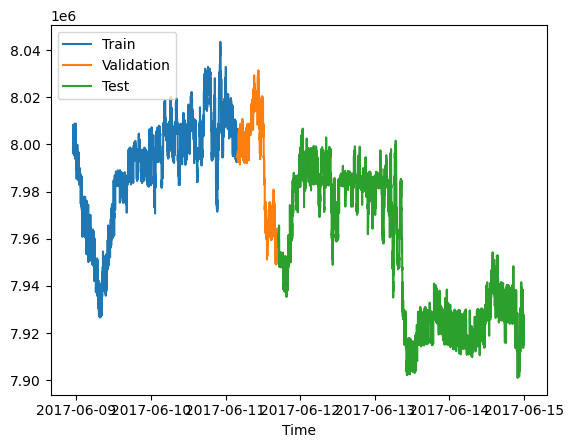

In [17]:
import matplotlib.pyplot as plt

plt.plot(Y_train)
plt.plot(Y_validation)
plt.plot(Y_test)
plt.xlabel("Time")
plt.legend(["Train", "Validation", "Test"], loc="upper left")

## Conclusion

LLM is a good asset for a data analyst toolbox, but it needs to be used with caution, as it is a black box model and it can be hard to understand the results.

The results may vary wildly depending on the model used, for this case it was used [Meta-Llama-3-8B-Instruct](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) an 8 billion parameters model, this is considered a small model now days and it is not the best model for this task, but it is the one that is available for free.

### Loras and fine-tuning

The best way to move forward and drastically improve the results is to fine-tune the model, but for this the data will need to be manually labeled and reviewed by someone with deep understanding of the data.

### Future work

This lays the groundwork for using LLMs with BibMon, the are to create better finetunes and instructions for the models to be able to better understand the data and provide better results.

Maybe in the future we can have a model that can understand the data and provide insights on the data, but for now we are limited to the current models and their capabilities.

Also possible future embedding of the LLM using llamacpp to the codebase so we do not need to call external APIs, but this may introduce too much dead weight to the codebase and it may not be worth it.
